# Practice Session 09: Viral Propagation
Author: <font color="blue">Rubén Vera Martínez</font>

E-mail: <font color="blue">ruben.vera01@estudiant.upf.edu</font>

Date: <font color="blue">02/11/2021</font>

# 1. The SFHH Conference Dataset

In [ ]:
import io
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
INPUT_FILENAME = "sfhh-conference-2009.csv"

In [ ]:
# LEAVE AS-IS

# Create a new undirected graph
g = nx.Graph()

with io.open(INPUT_FILENAME) as input_file:
    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')
    
    # Iterate through records, each record is a dictionary
    for record in reader:
        
        # Add one edge per record
        g.add_edge(record['Source'], record['Target'])

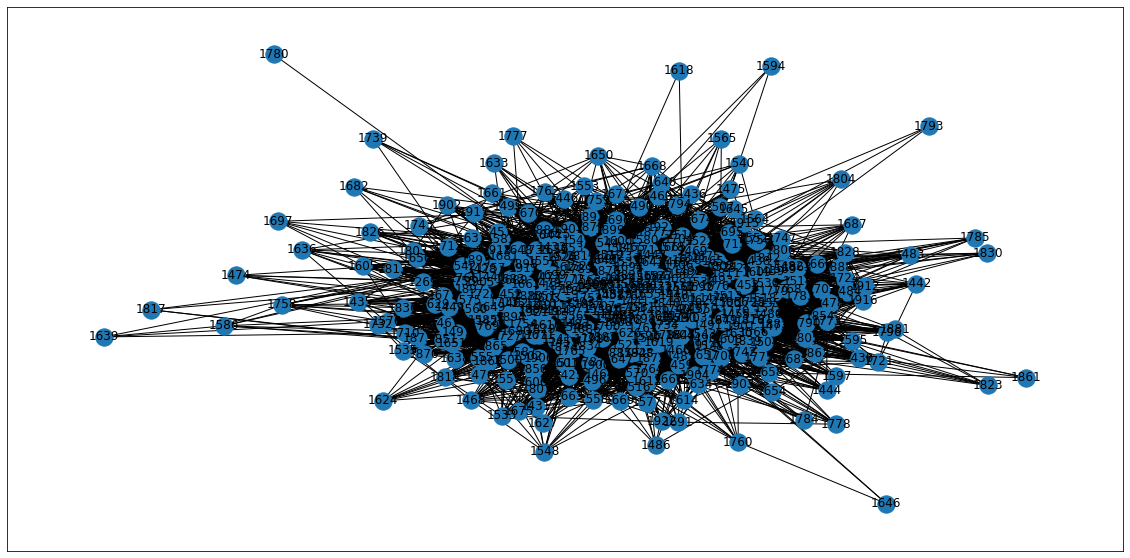

In [ ]:
# LEAVE AS-IS

# Create an empty figure; feel free to change size to accommodate to your screen
plt.figure(figsize=(20,10))

# Draw the graph
nx.draw_networkx(g)

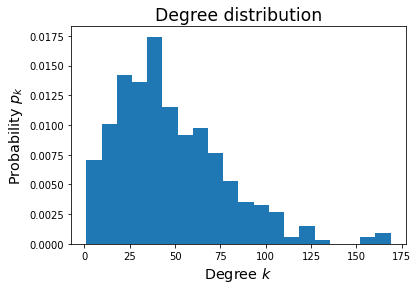

Degree: 47.5 +/- 30.1, range [1, 169]


In [ ]:
# LEAVE AS-IS

def plot_degree_dist(graph):
    
    # Obtain the sequence of degree of nodes
    # Function graph.degree() return tuples (node,degree)
    degrees = [degree_tuple[1] for degree_tuple in graph.degree()]
    
    # Draw the histogram of the degree
    plt.hist(degrees, density=True, bins=20)
    plt.title("Degree distribution", fontdict={'fontsize': 'xx-large'})
    plt.xlabel("Degree $k$", fontdict={'fontsize': 'x-large'})
    plt.ylabel("Probability $p_k$", fontdict={'fontsize': 'x-large'})
    plt.show()
    
    # Print some degree statistics
    print("Degree: {:.1f} +/- {:.1f}, range [{:d}, {:d}]".format(
        np.mean(degrees), np.std(degrees), np.min(degrees), np.max(degrees)))
    
plot_degree_dist(g)

Esta red no es una red libre de escala por el hecho de que la desviación standard no equivale al cuadrado del average.

# 2. Independent cascade model

In [ ]:
def infect_recursive(graph, starting_node, beta, infected):
  for neighbour in graph.neighbors(starting_node):
    if infected[neighbour] == False:
      r = random.uniform(0,1)
      if r < beta:
        infected[neighbour] = True
        infect_recursive(graph, neighbour, beta, infected)#Al infectarse el vecino, ha de infectar a los vecinos del vecino

In [ ]:
def simulate_independent_cascade(graph, starting_node, beta):
    infected = dict([(node, False) for node in graph.nodes()])
    infected[starting_node] = True
    infect_recursive(graph, starting_node, beta, infected)
    return infected

In [ ]:
def simulate_multiple_independent_cascades(graph, beta, repetitions):
  d = dict([(node, False) for node in graph.nodes()])
  sumatorio = 0
  for i in range(repetitions):
    node = random.choice(list(graph.nodes()))
    d = simulate_independent_cascade(graph, node, beta)
    sumatorio += sum(d.values())
  return sumatorio/(repetitions*graph.number_of_nodes())


In [ ]:
# LEAVE AS-IS

REPETITIONS=100
for beta in [0.01, 0.1, 0.2, 0.9, 1.0]:
    print("Beta={:.2f}; Fraction of infected={:.6f} (average of {:d} runs)".format(
        beta,
        simulate_multiple_independent_cascades(g, beta, REPETITIONS),
        REPETITIONS
    ))


Beta=0.01; Fraction of infected=0.005186 (average of 100 runs)
Beta=0.10; Fraction of infected=0.840844 (average of 100 runs)
Beta=0.20; Fraction of infected=0.926452 (average of 100 runs)
Beta=0.90; Fraction of infected=0.999777 (average of 100 runs)
Beta=1.00; Fraction of infected=1.000000 (average of 100 runs)


Text(0, 0.5, 'Nodes infected')

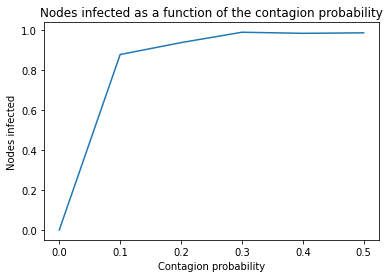

In [ ]:
beta = [0.0,0.1,0.2,0.3,0.4,0.5]
x_vals = sorted(beta)
y_vals = [simulate_multiple_independent_cascades(g, x, 100) for x in x_vals]

plt.plot(x_vals, y_vals)
plt.title("Nodes infected as a function of the contagion probability")
plt.xlabel("Contagion probability")
plt.ylabel("Nodes infected")

Se ve como rapidamente se infectan todos los nodos aunque la probabilidad de contagio sea relativamente baja. Concretamente con probabilidad 0.1, casi el 90% de los nodos estan contagiados y con probabilidad 0.2 mas del 90% estan ya contagiados. Esto sucede porque se esta iterando recursivamente sobre todos los vecinos de un nodo con probabilidad "beta" por lo cual un nodo puede ser infectado con probabilidad "beta" numerosas veces lo que hace que la probabilidad de ser infectado realmente sea mayor a "beta"

# 3. Reduce maximum degree

In [ ]:
def graph_max_degree(graph, max_degree):
  g = nx.Graph()
  for node in graph.nodes():
    g.add_node(node)
  edges = np.random.permutation(graph.edges())
  for u,v in edges:
    if g.degree(u) < max_degree and g.degree(v) < max_degree:
      g.add_edge(u,v)
  return g

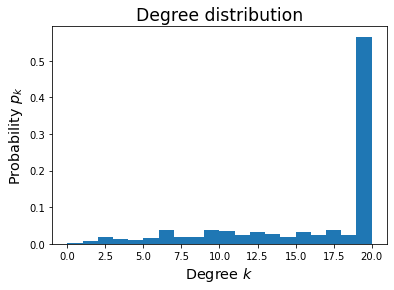

Degree: 15.9 +/- 5.6, range [0, 20]


In [ ]:
# LEAVE AS-IS

# Reduce the max degree of the graph
gmax = graph_max_degree(g, 20)

# If you notice nodes with degree larger than specified,
# it means your graph_max_degree function is deffective.
plot_degree_dist(gmax)

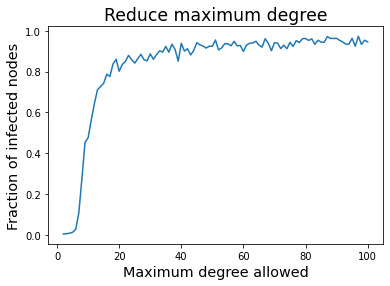

In [ ]:
x_vals = sorted(np.arange(2,101,1))
y_vals = [simulate_multiple_independent_cascades(graph_max_degree(g, x),0.2,100) for x in x_vals]

plt.plot(x_vals, y_vals)
plt.title("Reduce maximum degree", fontdict={'fontsize':'xx-large'})
plt.xlabel("Maximum degree allowed", fontdict={'fontsize':'x-large'})
plt.ylabel("Fraction of infected nodes", fontdict={'fontsize':'x-large'})
plt.show()

A medida que los nodos tienen mas contacto con otros nodos, rapidamente se ve como el porcentaje de nodos infectados crece. Para asegurarnos que menos de la mitad de los nodos se infectaran habria que hacer que un nodo no tuviese contacto y por lo tanto no tuviese enlace con mas de 10 nodos aproximadamente. En el anterior grafico se ha comentado que al tener muchos nodos conectados entre ellos la probabilidad realmente de ser infectado era mayor a beta, comparandolo con este grafico confirmamos la hipotesis ya que vemos que si un nodo esta conectado a menos nodos, la fraccion de nodos infectados es mucho menor ya que el numero de veces que un nodo intentara ser infectado sera inferior.

# 4. Random vs friendship paradox immunization

In [ ]:
def give_immunity_random(graph, fraction):
  i = 0
  immunity = dict([(node, False) for node in graph.nodes()])
  while i < round(fraction*graph.number_of_nodes()):
    node_to_immunize = random.choice(list(immunity))
    if immunity[node_to_immunize] == False:
      immunity[node_to_immunize] = True
      i+=1   
  return immunity

In [ ]:
# LEAVE AS-IS

def test_immunize(graph, method, values):
    for fraction in values:
        immunity = method(g, fraction)
        number_immunized = sum(immunity.values())
        number_not_immunized = len(immunity) - number_immunized
        fraction_immunized = number_immunized / (number_immunized + number_not_immunized)
        print("Immunized {:.1f}% of nodes; got a dictionary with {:d} 'True' and {:d} 'False' values ({:.1f}% 'True')".format(
            fraction*100,
            number_immunized,
            number_not_immunized,
            fraction_immunized*100
        ))

test_immunize(g, give_immunity_random, [0.1, 0.3, 0.7])

Immunized 10.0% of nodes; got a dictionary with 40 'True' and 363 'False' values (9.9% 'True')
Immunized 30.0% of nodes; got a dictionary with 121 'True' and 282 'False' values (30.0% 'True')
Immunized 70.0% of nodes; got a dictionary with 282 'True' and 121 'False' values (70.0% 'True')


In [ ]:
def give_immunity_random_friend(graph, fraction):
  i = 0
  immunity = dict([(node, False) for node in graph.nodes()])
  while i < round(fraction*graph.number_of_nodes()):
    node_random = random.choice(list(immunity))
    node_to_immunize = random.choice(list(graph.neighbors(node_random)))
    if immunity[node_to_immunize] == False:
      immunity[node_to_immunize] = True
      i+=1   
  return immunity

In [ ]:
# LEAVE AS-IS

test_immunize(g, give_immunity_random_friend, [0.1, 0.3, 0.7])

Immunized 10.0% of nodes; got a dictionary with 40 'True' and 363 'False' values (9.9% 'True')
Immunized 30.0% of nodes; got a dictionary with 121 'True' and 282 'False' values (30.0% 'True')
Immunized 70.0% of nodes; got a dictionary with 282 'True' and 121 'False' values (70.0% 'True')


In [ ]:
def infect_recursive_immune(graph, starting_node, beta, infected, immune):
  for neighbour in graph.neighbors(starting_node):
    if infected[neighbour] == False and immune[neighbour] != True:
      r = random.uniform(0,1)
      if r < beta:
        infected[neighbour] = True
        infect_recursive_immune(graph, neighbour, beta, infected, immune)#Al infectarse el vecino, ha de infectar a los vecinos del vecino

In [ ]:
def simulate_independent_cascade_immune(graph, starting_node, beta, immune):
    infected = dict([(node, False) for node in graph.nodes()])
    if immune[starting_node] != True:
      infected[starting_node] = True
      infect_recursive_immune(graph, starting_node, beta, infected, immune)
    return infected

In [ ]:
def simulate_multiple_independent_cascades_immune(graph, beta, repetitions, immune):
  d = dict([(node, False) for node in graph.nodes()])
  sumatorio = 0
  for repetition in range(repetitions):
    n = random.choice(list(graph.nodes()))
    d = simulate_independent_cascade_immune(graph, n, beta, immune)
    sumatorio += sum(d.values())
  return sumatorio/(repetitions*graph.number_of_nodes())

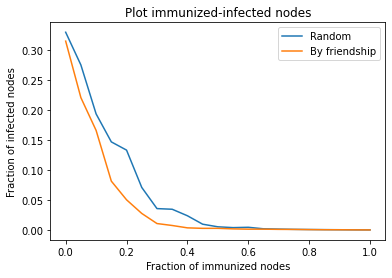

In [ ]:
BETA = 0.03
REPETITIONS = 500
x_vals = sorted(np.arange(0.00,1.05,0.05))
y_vals = [simulate_multiple_independent_cascades_immune(g,BETA,REPETITIONS, give_immunity_random(g, x)) for x in x_vals]
y_vals2 = [simulate_multiple_independent_cascades_immune(g,BETA,REPETITIONS, give_immunity_random_friend(g, x)) for x in x_vals]
plt.plot(x_vals, y_vals, label = "Random")
plt.plot(x_vals, y_vals2, label = "By friendship")
plt.legend(loc = "upper right")
plt.title("Plot immunized-infected nodes")
plt.xlabel("Fraction of immunized nodes")
plt.ylabel("Fraction of infected nodes")
plt.show()



Los dos metodos decrecen más o menos igual por el hecho de que los dos tienen procesos aleatorios aunque el metodo de random tiene menor pendiente por el hecho de que hacemos un muestreo directo por lo cual tratamos de infectar al mismo nodo en caso que no este immunizado, proceso totalmente aleatorio sin tener en cuenta el grado del nodo. En el caso de friendship tiene mayor pendiente ya que priorizara a los nodos con mayor grado si escogemos un vecino de un nodo ya que los nodos con mayor grado tendran mas probabilidad de ser escogidos y por lo tanto estar immune. Si un nodo con grado alto es escogido al tener conexión con más nodos por lo explicado más arriba en esta practica, la fraccion de immunizados crecerá mas rapidamente y por lo tanto la de infectados decrecera mas rapidamente.

# 5. Limitations

Las limitaciones de estas simulaciones són que cada pandemia es diferente y por consecuente actua de manera diferente. Hay diferentes tipos de pandemias:
- SI model: Tipo de pandemia donde una vez infectado ya no puedes volver a ser susceptible de coger la enfermedad, al no tener cura, te quedaras asi para siempre, como por ejemplo el VIH.
- SIS model: Tipo de pandemia donde una vez infectado, existe una cura con la cual puedes recuperarte y volver a ser susceptible de contagiarte.
- SIR mode: Tipo de pandemia donde una vez infectado o te haces inmune o te mueres y por lo tanto se te elimina de lo que seria un hipotetico grafo. En este modelo, cuando el tiempo tienda a infinito tendremos 0 personas susceptibles de contagiarse y 0 infectados.

Por lo tanto, por lo mencionado y viendo lo diferente que puede ser una pandemia, se puede observar que aunque podemos extraer información útil para ser usada, primero habria que tener en cuenta muchas otras cosas.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>